In [15]:
import numpy as np
import pandas
from sklearn.utils import resample
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import dirichlet, norm, multinomial, gamma

In [2]:
low = 0
high = 20
total_samp = 10
vect = np.random.randint(low,high,total_samp)
vect, vect.mean()

(array([ 3,  0,  0,  1, 14,  9, 12, 19, 12,  3]), 7.3)

In [3]:
[0]*vect.shape[0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [4]:
n_samples = 1000000
samps = [resample(vect, replace=True) for _ in range(n_samples)]
s_means = np.array([s.mean() for s in samps])

In [5]:
num_bins = 80
bins = np.linspace(-1, high, num_bins)

Text(0.5, 1.0, 'Regular Bootstrap')

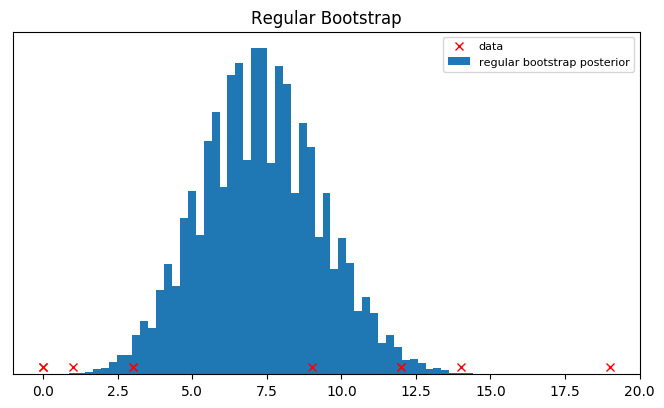

In [6]:
plt.figure(figsize=[7,4], dpi=100)
plt.hist(s_means, bins, label='regular bootstrap posterior', density=True)
plt.plot(vect, [0.005]*vect.shape[0], 'rx', label='data')
plt.tight_layout()
plt.legend(fontsize=8)
plt.xlim(-1, high)
plt.yticks([])
plt.title('Regular Bootstrap')

In [7]:
## Using Dirichlet
vect

array([ 3,  0,  0,  1, 14,  9, 12, 19, 12,  3])

In [8]:
dirichlet_samples = dirichlet([1] * len(vect)).rvs(100000)
dirichlet_samples.shape

(100000, 10)

In [9]:
s_means

array([ 6.7,  7.1, 11.2, ...,  4.7,  6.6,  5.7])

In [10]:
(vect*dirichlet_samples).sum(axis=1)

array([5.62139162, 5.72462353, 6.5435771 , ..., 6.54023069, 9.15522934,
       6.9077653 ])

In [11]:
bayes_boots_samples = (vect * dirichlet_samples).sum(axis=1)
bayes_boots_samples.shape

(100000,)

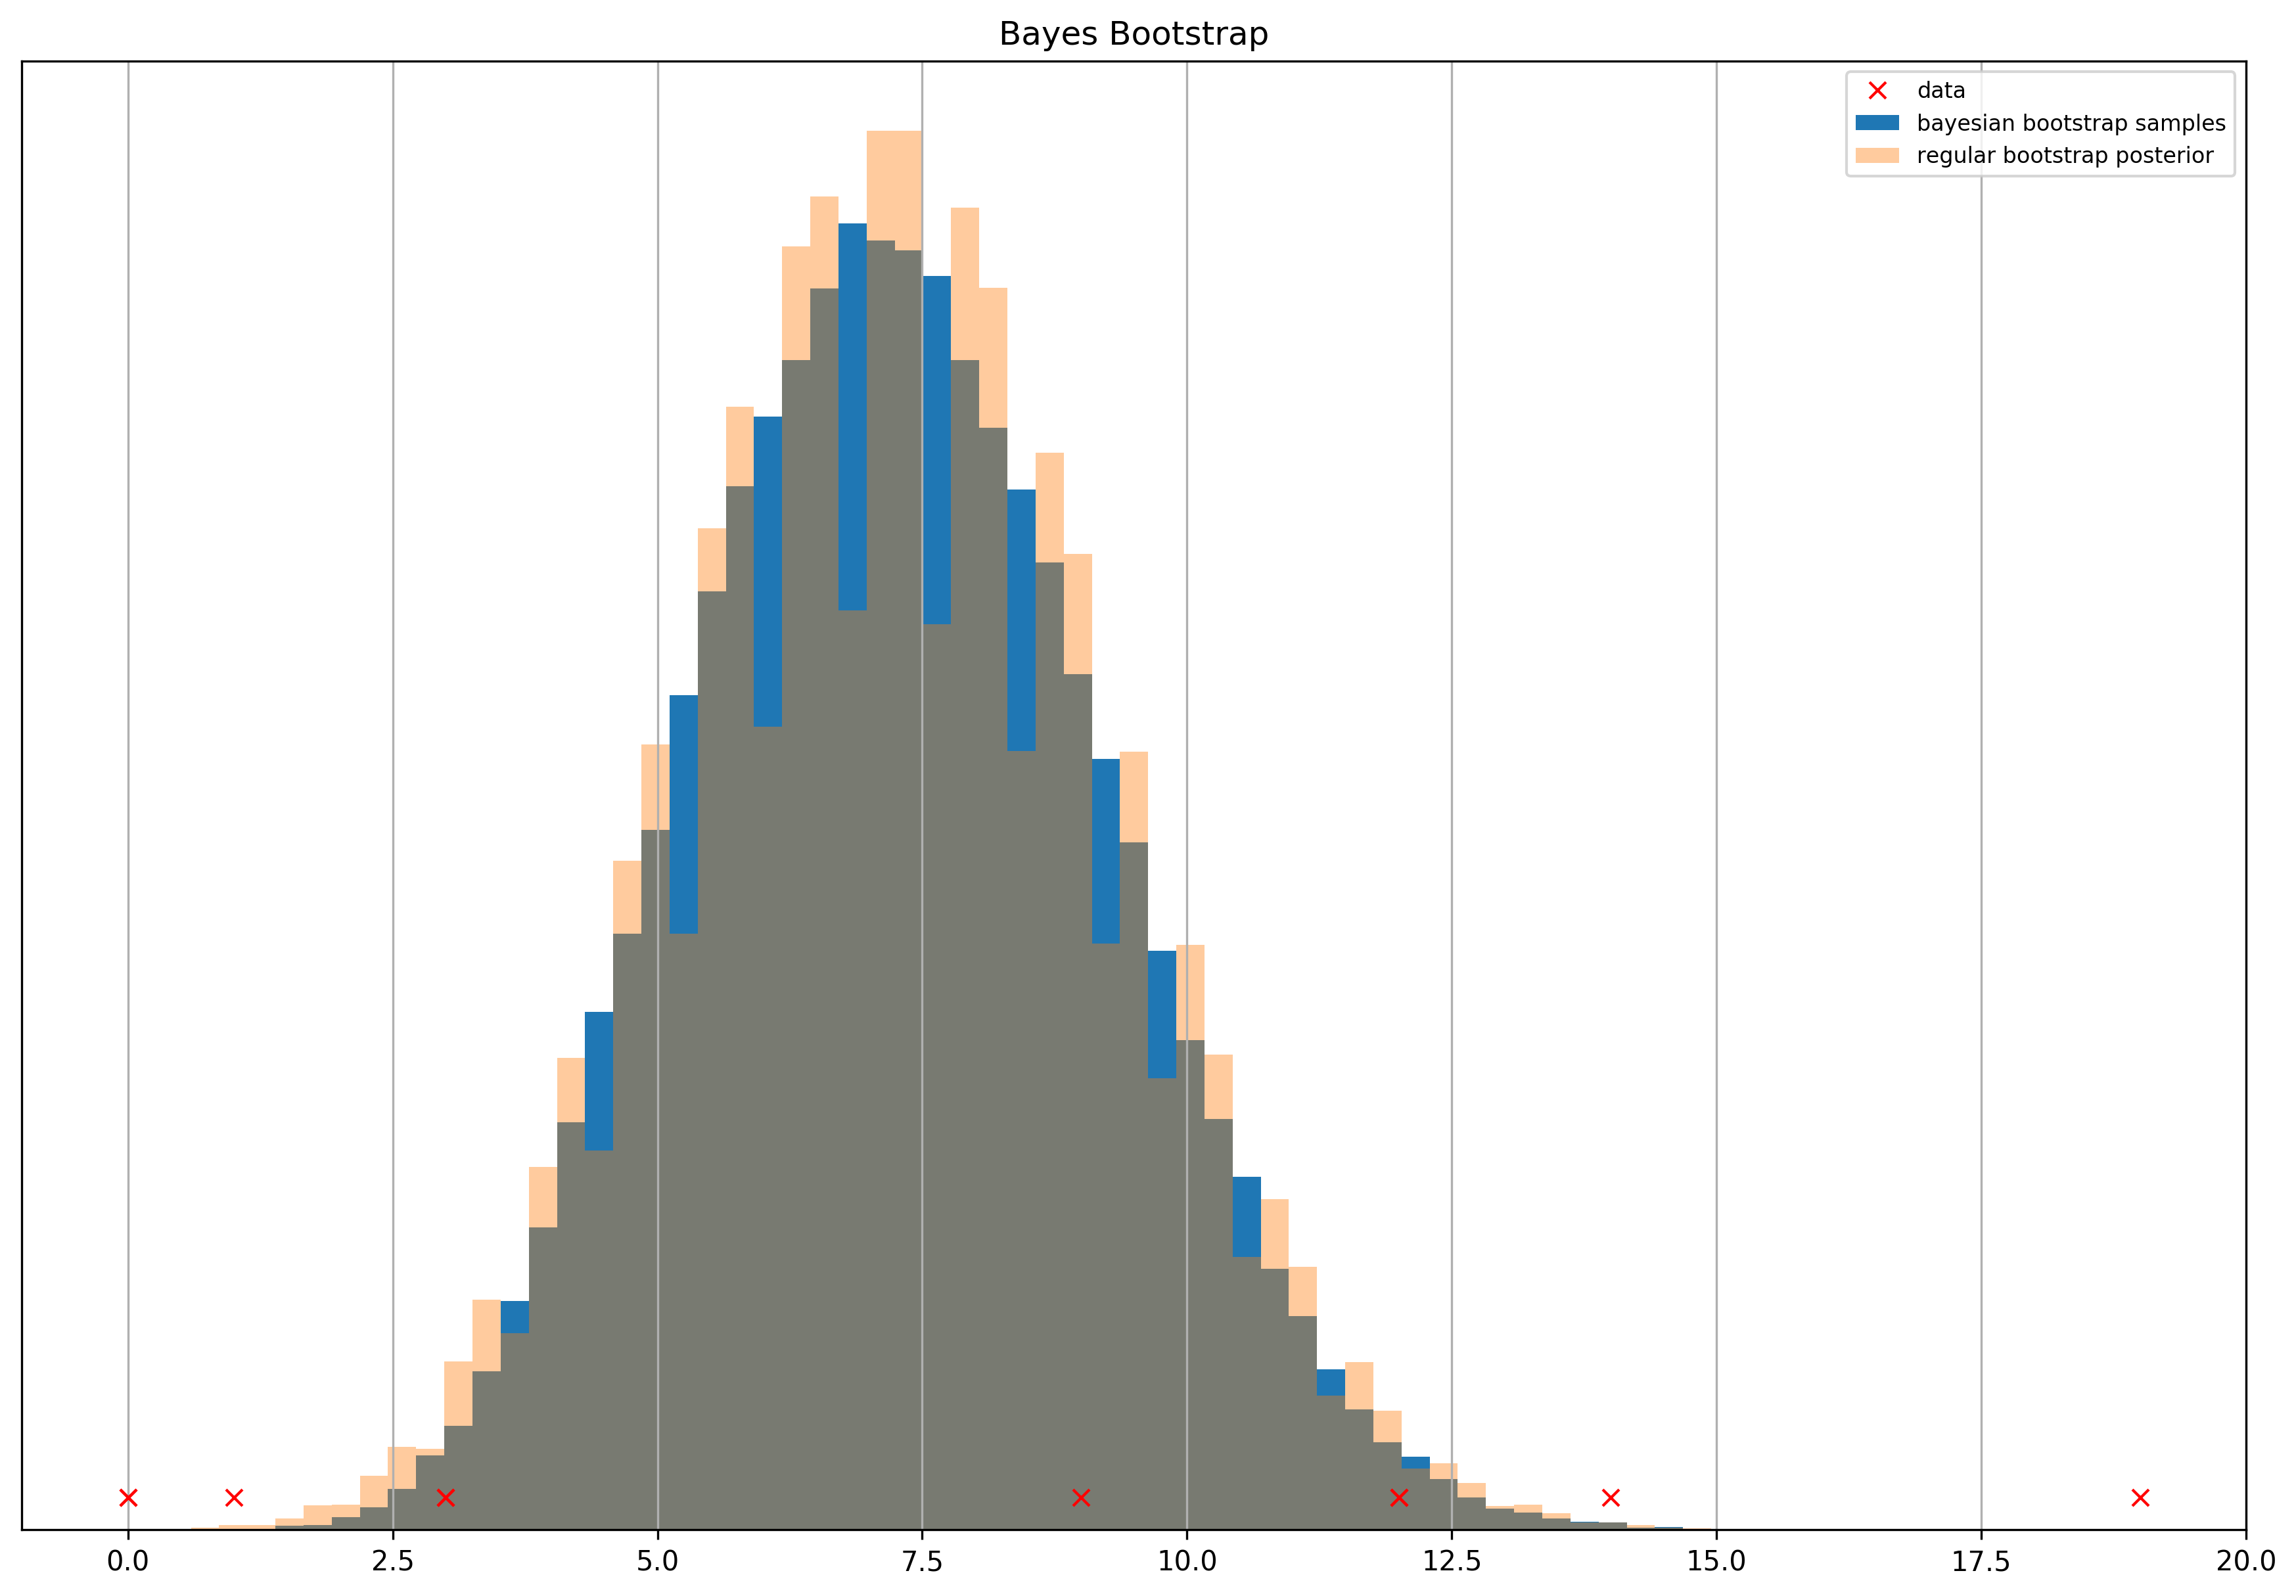

In [12]:
plt.figure(figsize=[12,8], dpi=300)
plt.hist(bayes_boots_samples, bins, label='bayesian bootstrap samples', density=True)
plt.hist(s_means, bins, alpha=0.4, label='regular bootstrap posterior', density=True)
plt.plot(vect, [0.005]*vect.shape[0], 'rx', label='data')
plt.tight_layout()
plt.legend(fontsize=8)
plt.xlim(-1, high)
plt.yticks([])
plt.title('Bayes Bootstrap')
plt.grid()

In [13]:
class ExactGaussianInference:
    
    # initializing with prior paramters
    def __init__(self, prior_mu, prior_sigma, likelihood_sigma):
        
        # storing
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        self.post_mu = prior_mu
        self.post_sigma = prior_sigma
        self.likelihood_sigma = likelihood_sigma
                
    # fitting the posterior for the mean
    def get_posterior(self, obs):
        
        # checking if there is any observation before proceeding
        if len(obs) > 0:
        
            # calculating needed statistics for the observations
            obs_mu = np.mean(obs)
            obs_sum = np.sum(obs)
            obs_n = len(obs)

            # updating posterior mean
            self.post_mu = (1/(1/self.prior_sigma**2 + obs_n/self.likelihood_sigma**2) *
                            (self.prior_mu/self.prior_sigma**2 + obs_sum/self.likelihood_sigma**2))

            # updating posterior sigma
            self.post_sigma = (1/self.prior_sigma**2 + obs_n/self.likelihood_sigma**2)**(-1)
            
        # return posterior
        return norm(self.post_mu, np.sqrt(self.post_sigma))

In [35]:
class BootstrapPosteriorInference:
    
    # initializing with prior paramters
    def __init__(self, n_draws):
        
        # storing
        self.n_draws = n_draws
                
    # fitting the posterior for the mean
    def get_posterior(self, obs):
        # checking if there is any observation before proceeding
        if len(obs) > 0:

            # running bootstrap samples
            boots_samples = np.array([resample(obs) for _ in range(self.n_draws)])
            posterior_draws = boots_samples.mean(axis=1)

            # return posterior density via samples
            return posterior_draws

        else:
            print('Cannot run with no observations!')
            raise

In [36]:
class BayesianBootstrapPosteriorInference:
    
    # initializing with prior paramters
    def __init__(self, n_draws):
        
        # storing
        self.n_draws = n_draws
                
    # fitting the posterior for the mean
    def get_posterior(self, obs):
        
        # checking if there is any observation before proceeding
        if len(obs) > 0:

            # running bootstrap samples
            dir_samples = dirichlet([1] * len(obs)).rvs(self.n_draws)
            posterior_draws = (dir_samples * obs).sum(axis=1)

            # return posterior density via samples
            return posterior_draws

        else:
            print('Cannot run with no observations!')
            raise

In [37]:
np.random.seed(100)
sample_9 = np.random.normal(2, 1, size=9)
sample_7 = deepcopy(sample_9[:7])
sample_5 = deepcopy(sample_9[:5])
sample_3 = deepcopy(sample_9[:3])

sample_list = [sample_3, sample_5, sample_7, sample_9]

In [38]:
sample_9

array([0.25023453, 2.3426804 , 3.1530358 , 1.74756396, 2.98132079,
       2.51421884, 2.22117967, 0.92995667, 1.81050417])

In [39]:
sample_7

array([0.25023453, 2.3426804 , 3.1530358 , 1.74756396, 2.98132079,
       2.51421884, 2.22117967])

In [40]:
sample_5

array([0.25023453, 2.3426804 , 3.1530358 , 1.74756396, 2.98132079])

In [41]:
sample_3

array([0.25023453, 2.3426804 , 3.1530358 ])

In [42]:
sample_list

[array([0.25023453, 2.3426804 , 3.1530358 ]),
 array([0.25023453, 2.3426804 , 3.1530358 , 1.74756396, 2.98132079]),
 array([0.25023453, 2.3426804 , 3.1530358 , 1.74756396, 2.98132079,
        2.51421884, 2.22117967]),
 array([0.25023453, 2.3426804 , 3.1530358 , 1.74756396, 2.98132079,
        2.51421884, 2.22117967, 0.92995667, 1.81050417])]

In [43]:
egi = ExactGaussianInference(0, 100, 1)

# calculating posteriors
exact_post_list = []
for sample in sample_list:
    exact_post_list.append(egi.get_posterior(sample))

In [45]:
# configuring bootstrap posterior
bpi = BootstrapPosteriorInference(10000)

# calculating posteriors
boots_post_list = []
for sample in sample_list:
    boots_post_list.append(bpi.get_posterior(sample))

In [47]:
boots_post_list[0]

array([0.94771649, 2.88291734, 1.21783495, ..., 1.21783495, 1.21783495,
       2.18543538])

In [48]:
def plot_fig_1():

    for i in range(4):

        post = exact_post_list[i]
        sample = sample_list[i]

        plt.subplot(2, 4, i+1)
        plt.fill_between(x_grid, post.pdf(x_grid), alpha=0.5, label='exact\nposterior')
        plt.plot(sample, [0]*sample.shape[0], 'rx', label='data')
        plt.tight_layout()
        plt.legend(fontsize=8)
        plt.xlim(-1, 5)
        plt.ylim(bottom=-0.05*post.pdf(x_grid).max())
        plt.yticks([])
        plt.title(f'Exact, N = {sample.shape[0]}')

    for i in range(4):

        post = boots_post_list[i]
        sample = sample_list[i]

        plt.subplot(2, 4, i+5)
        h = plt.hist(post, alpha=0.5, bins = np.linspace(-1, 5, 80), label='bootstrap\nposterior', density=True)
        plt.plot(sample, [0]*sample.shape[0], 'rx', label='data')
        plt.tight_layout()
        plt.legend(fontsize=8)
        plt.xlim(-1, 5)
        plt.ylim(bottom=-0.05*h[0].max())
        plt.yticks([])
        plt.title(f'Classic Bootstrap, N = {sample.shape[0]}')

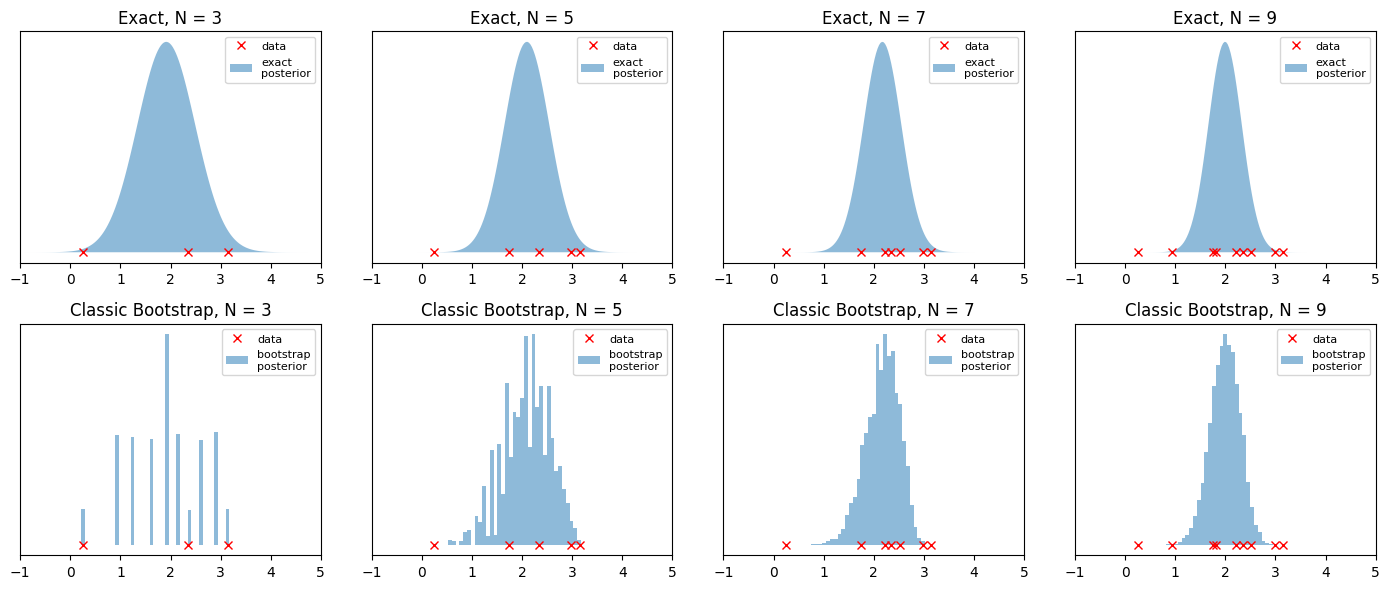

In [49]:
# grid for plotting pdf
x_grid = np.linspace(-1, 5, 200)

# opening figure
plt.figure(figsize=[14,6], dpi=100)

# plotting
plot_fig_1()